In [1]:
import cdsapi

In [5]:
# Step 2: Initialize the CDS API client
client = cdsapi.Client()

# Step 3: Define the dataset
dataset = "reanalysis-era5-land"

# Step 4: Test the connection with a simple request
# Let's start with a small test to verify the connection works
test_request = {
    "variable": "surface_solar_radiation_downwards_hourly",  # This is the ssrd variable
    "year": "2018",
    "month": "01",
    "day": "01",
    "time": "12:00",
    "area": [55, 5, 47, 16],  # Germany bounding box [north, west, south, east]
    "format": "netcdf"
}

print("Testing connection to CDS API...")
print(f"Dataset: {dataset}")
print(f"Client initialized: {client is not None}")

# Step 5: Get a bigger sample of data (a few days) - FIXED VERSION
sample_request = {
    "variable": "surface_solar_radiation_downwards",  # Correct variable name (without _hourly)
    "year": "2018",
    "month": ["01", "02"],  # January and February
    "day": [f"{i:02d}" for i in range(1, 6)],  # First 5 days of each month
    "time": [f"{i:02d}:00" for i in range(24)],  # All 24 hours
    "area": [55, 5, 47, 16],  # Germany bounding box [north, west, south, east]
    "format": "netcdf"
}

print("Downloading sample data...")
print(f"Time period: January-February 2018, first 5 days of each month")
print(f"Hours: All 24 hours")
print(f"Area: Germany")

# Download the sample data
sample_file = "sample_ssrd_germany_2018.nc"
result = client.retrieve(dataset, sample_request)
result.download(sample_file)

print(f"Sample data downloaded to: {sample_file}")
print("Sample data size: ~", len(sample_request["month"]) * len(sample_request["day"]) * 24, "hourly records")

2025-08-10 16:05:22,266 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-10 16:05:22,416 INFO Request ID is d6d11b37-357c-4aa3-841d-ac128bd3fffe


Testing connection to CDS API...
Dataset: reanalysis-era5-land
Client initialized: True
Time period: January-February 2018, first 5 days of each month
Hours: All 24 hours
Area: Germany


2025-08-10 16:05:22,474 INFO status has been updated to accepted
Recovering from HTTP error [500 Internal Server Error], attempt 1 of 500
Retrying in 120 seconds
2025-08-10 16:08:49,828 INFO status has been updated to successful


dc69a5e8f6c8961664ae5a1896b5ede6.zip:   0%|          | 0.00/1.95M [00:00<?, ?B/s]

Sample data downloaded to: sample_ssrd_germany_2018.nc
Sample data size: ~ 240 hourly records


Loading the extracted NetCDF file...

=== File Structure ===
Keys: ['number', 'valid_time', 'latitude', 'longitude', 'expver', 'ssrd']

=== SSRD Data ===
Shape: (240, 81, 111)
Data type: float32
Min value (clean): 0.0
Max value (clean): 9556890.0
Mean value (clean): 1924890.00
Units: J m**-2 (accumulated radiation)

Latitude range: 47.00 to 55.00
Latitude points: 81
Longitude range: 5.00 to 16.00
Longitude points: 111
Time points: 240
Time range: 1514764800 to 1517871600
Time units: seconds since 1970-01-01

=== Sample Data Point ===
Value at [0,0,0]: nan


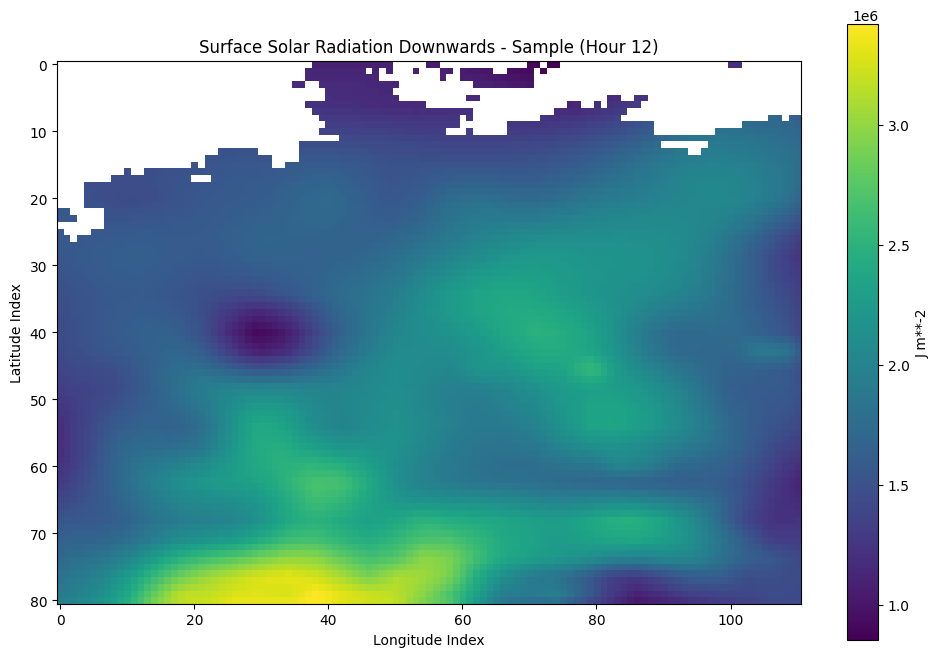


=== Converting to DataFrame ===
Sample DataFrame:
                 time  ssrd
0 2018-01-01 00:00:00   NaN
1 2018-01-01 01:00:00   NaN
2 2018-01-01 02:00:00   NaN
3 2018-01-01 03:00:00   NaN
4 2018-01-01 04:00:00   NaN

Total records: 240
Time range: 2018-01-01 00:00:00 to 2018-02-05 23:00:00

=== Sample Location Statistics ===
Mean SSRD: nan J m**-2
Max SSRD: nan J m**-2
Min SSRD: nan J m**-2


In [13]:
# Step 6: Examine the downloaded data - Fixed version
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Read the extracted NetCDF file using h5py
print("Loading the extracted NetCDF file...")
with h5py.File("data_0.nc", 'r') as f:
    print("\n=== File Structure ===")
    print("Keys:", list(f.keys()))
    
    # Get the ssrd data
    if 'ssrd' in f:
        ssrd_data = f['ssrd'][:]
        print(f"\n=== SSRD Data ===")
        print(f"Shape: {ssrd_data.shape}")
        print(f"Data type: {ssrd_data.dtype}")
        
        # Handle NaN values
        ssrd_clean = np.where(ssrd_data == 3.40282347e+38, np.nan, ssrd_data)
        print(f"Min value (clean): {np.nanmin(ssrd_clean)}")
        print(f"Max value (clean): {np.nanmax(ssrd_clean)}")
        print(f"Mean value (clean): {np.nanmean(ssrd_clean):.2f}")
        print(f"Units: J m**-2 (accumulated radiation)")
        
        # Get coordinates
        if 'latitude' in f:
            lats = f['latitude'][:]
            print(f"\nLatitude range: {lats.min():.2f} to {lats.max():.2f}")
            print(f"Latitude points: {len(lats)}")
        
        if 'longitude' in f:
            lons = f['longitude'][:]
            print(f"Longitude range: {lons.min():.2f} to {lons.max():.2f}")
            print(f"Longitude points: {len(lons)}")
        
        if 'valid_time' in f:
            time_data = f['valid_time'][:]
            print(f"Time points: {len(time_data)}")
            print(f"Time range: {time_data.min()} to {time_data.max()}")
            print(f"Time units: seconds since 1970-01-01")
        
        # Show a sample slice (first time, first lat, first lon)
        print(f"\n=== Sample Data Point ===")
        print(f"Value at [0,0,0]: {ssrd_clean[0,0,0]}")
        
        # Create a simple visualization of one time slice
        plt.figure(figsize=(12, 8))
        plt.imshow(ssrd_clean[12, :, :], cmap='viridis')  # Hour 12 (noon)
        plt.colorbar(label='J m**-2')
        plt.title('Surface Solar Radiation Downwards - Sample (Hour 12)')
        plt.xlabel('Longitude Index')
        plt.ylabel('Latitude Index')
        plt.show()
        
        # Convert to pandas DataFrame for easier manipulation
        print("\n=== Converting to DataFrame ===")
        # Create time index from valid_time (seconds since 1970-01-01)
        time_index = [datetime(1970, 1, 1) + timedelta(seconds=int(t)) for t in time_data]
        
        # Create a sample DataFrame for one location
        sample_df = pd.DataFrame({
            'time': time_index,
            'ssrd': ssrd_clean[:, 0, 0]  # First lat/lon point
        })
        print("Sample DataFrame:")
        print(sample_df.head())
        print(f"\nTotal records: {len(sample_df)}")
        
        # Show time range
        print(f"Time range: {sample_df['time'].min()} to {sample_df['time'].max()}")
        
        # Basic statistics for the sample location
        print(f"\n=== Sample Location Statistics ===")
        print(f"Mean SSRD: {sample_df['ssrd'].mean():.2f} J m**-2")
        print(f"Max SSRD: {sample_df['ssrd'].max():.2f} J m**-2")
        print(f"Min SSRD: {sample_df['ssrd'].min():.2f} J m**-2")
        
    else:
        print("SSRD variable not found in the file")
        print("Available variables:", list(f.keys()))